# Take-home Final Exam


###Produce descriptive statistics of all variables including missing values. Identify predictors that may help predict MIS_Status using descriptive statistics and visualization. How is the outcome variable MIS_Status distributed?


In [106]:
%pip install dmba

In [107]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, recall_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
import math
from scipy.stats import chi2


In [108]:
DATA = Path('/content/sample_data/')
sba_df = pd.read_csv(DATA / 'SBAcase.11.13.17.csv')
sba_df


,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
0,0,1004285007,SIMPLEX OFFICE SOLUTIONS,ANAHEIM,CA,92801,CALIFORNIA BANK & TRUST,CA,532420,15074,...,0,30000,15000,0,0,0.50,0,1080,16175.0,0
1,1,1004535010,DREAM HOME REALTY,TORRANCE,CA,90505,CALIFORNIA BANK & TRUST,CA,531210,15130,...,0,30000,15000,0,0,0.50,1,1680,17658.0,0
2,0,1005005006,"Winset, Inc. dba Bankers Hill",SAN DIEGO,CA,92103,CALIFORNIA BANK & TRUST,CA,531210,15188,...,0,30000,15000,0,0,0.50,0,1080,16298.0,0
3,1,1005535001,Shiva Management,SAN DIEGO,CA,92108,CALIFORNIA BANK & TRUST,CA,531312,15719,...,0,50000,25000,0,0,0.50,0,1080,16816.0,0
4,1,1005996006,"GOLD CROWN HOME LOANS, INC",LOS ANGELES,CA,91345,SBA - EDF ENFORCEMENT ACTION,CO,531390,16840,...,0,343000,343000,0,1,1.00,0,7200,24103.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,1,9893874006,MEGA VIDEO & WIRELESS HIGHLAND,HIGHLAND,CA,92346,UNITI BANK,CA,532230,16838,...,0,150000,75000,1,0,0.50,0,1800,18691.0,0
2098,1,9901143004,MOVING CONNECTION & CARL'S TRA,EL CAJON,CA,92021,ZIONS FIRST NATIONAL BANK,UT,532120,13530,...,0,99000,79200,0,1,0.80,0,9000,22545.0,0
2099,0,9903293007,"A.J. STUDIO RENTALS, INC.",CAMARILLO,CA,93012,CITY NATIONAL BANK,CA,532120,13531,...,0,50000,40000,0,0,0.80,0,2520,16124.0,0
2100,1,9925643006,TAHOE MOTION PICTURE RENTALS,SUN VALLEY,CA,91352,CITY NATIONAL BANK,CA,532120,13542,...,0,500000,375000,0,0,0.75,0,3600,17265.0,0


In [109]:
sba_df.columns

Index(['Selected', 'LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank',
       'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate',
       'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr',
       'GrAppv', 'SBA_Appv', 'New', 'RealEstate', 'Portion', 'Recession',
       'daysterm', 'xx', 'Default'],
      dtype='object')

###**Descriptive statistics for continuous quantitative variables**

In [110]:
sba_df.describe() #only variables with numeric format

,Selected,LoanNr_ChkDgt,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
count,2102.000000,2.102000e+03,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2101.000000,2102.000000,...,2.102000e+03,2.102000e+03,2.102000e+03,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2099.000000,2102.000000
mean,0.500000,4.469172e+09,92698.612274,531630.902950,16179.587060,2004.035680,126.980495,10.150809,1.153736,2.549952,...,2.002908e+04,2.330641e+05,1.891759e+05,0.154139,0.274500,0.671055,0.068506,3809.414843,20076.896141,0.326356
std,0.500119,2.530069e+09,1878.208435,521.836986,1454.931276,4.006321,93.798944,34.402420,0.362099,8.010175,...,7.543229e+04,3.436310e+05,2.989268e+05,0.361168,0.446368,0.186519,0.252673,2813.968318,2854.510377,0.468991
min,0.000000,1.004285e+09,65757.000000,531110.000000,10554.000000,1989.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,4.500000e+03,2.250000e+03,0.000000,0.000000,0.296770,0.000000,0.000000,11524.000000,0.000000
25%,0.000000,2.392978e+09,91402.000000,531210.000000,15695.750000,2003.000000,60.000000,2.000000,1.000000,0.000000,...,0.000000e+00,3.000000e+04,1.500000e+04,0.000000,0.000000,0.500000,0.000000,1800.000000,18316.500000,0.000000
50%,0.500000,3.621730e+09,92559.500000,531312.000000,16556.000000,2005.000000,84.000000,3.000000,1.000000,0.000000,...,0.000000e+00,6.100000e+04,4.168000e+04,0.000000,0.000000,0.500000,0.000000,2520.000000,19270.000000,0.000000
75%,1.000000,6.551607e+09,94127.750000,532230.000000,17149.750000,2007.000000,240.000000,8.000000,1.000000,2.000000,...,1.507350e+04,3.000000e+05,2.397562e+05,0.000000,1.000000,0.850000,0.000000,7200.000000,22335.000000,1.000000
max,1.000000,9.958873e+09,96161.000000,533110.000000,18911.000000,2012.000000,306.000000,650.000000,2.000000,130.000000,...,1.509550e+06,2.350000e+06,2.115000e+06,1.000000,1.000000,1.000000,1.000000,9180.000000,27598.000000,1.000000


In [111]:
#have more than 1 variable, so making a list of all numeric continuous variables
numeric_continuous_variables = ['GrAppv', 'SBA_Appv', 'ChgOffPrinGr', 'DisbursementGross', 'BalanceGross', 'Portion', 'xx']

descriptive_stats = pd.DataFrame({
    'mean': sba_df[numeric_continuous_variables].mean(),
    'std': sba_df[numeric_continuous_variables].std(),
    'min': sba_df[numeric_continuous_variables].min(),
    'max': sba_df[numeric_continuous_variables].max(),
    'median': sba_df[numeric_continuous_variables].median(),
    'count': sba_df[numeric_continuous_variables].count(),
    'missing': sba_df[numeric_continuous_variables].isnull().sum()
})

descriptive_stats

,mean,std,min,max,median,count,missing
GrAppv,233064.062322,343631.007288,4500.00000,2350000.0,61000.0,2102,0
SBA_Appv,189175.887726,298926.803050,2250.00000,2115000.0,41680.0,2102,0
ChgOffPrinGr,20029.081827,75432.286186,0.00000,1509550.0,0.0,2102,0
DisbursementGross,242737.212179,338286.101816,4835.00000,2315000.0,100000.0,2102,0
BalanceGross,0.000000,0.000000,0.00000,0.0,0.0,2102,0
Portion,0.671055,0.186519,0.29677,1.0,0.5,2102,0
xx,20076.896141,2854.510377,11524.00000,27598.0,19270.0,2099,3


### **Frequency counts for other categorical variables**

In [112]:
sba_df.isna().sum()

,0
Selected,0
LoanNr_ChkDgt,0
Name,0
City,0
State,0
Zip,0
Bank,3
BankState,3
NAICS,0
ApprovalDate,0


In [113]:
#there are a lot of categorical variables, will create a list and then use a for loop to run there all the variables

categorical_variables = ['Name', 'City', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalFY', 'NewExist',
                        'FranchiseCode', 'UrbanRural', 'MIS_Status', 'RevLineCr', 'LowDoc',
                         'MIS_Status', 'New', 'RealEstate', 'Default', 'Recession']

for variable in categorical_variables:
    print(f"{variable}:")
    print(sba_df[variable].value_counts())
    print("\n")


Name:
Name
JEANETTE GARCIA & EDELMIRA TOR    3
U-SAVE AUTO RENTAL                3
SANTA BARBARA OLD TOWN TROLLEY    3
Charles & Michaela Gibbs dba F    3
RONNIE'S TUXEDOS                  3
                                 ..
Mi Ra Choi Realty                 1
PINNACLE HOMES & ESTATES INC.     1
CARMEN CARR                       1
T & T REAL ESTATE CORPORATION     1
RPM BANCORP INC                   1
Name: count, Length: 2005, dtype: int64


City:
City
LOS ANGELES             162
SAN DIEGO               111
SAN JOSE                 65
SAN FRANCISCO            39
SACRAMENTO               33
                       ... 
PALOS VERDES ESTATES      1
MIDDLETOWN                1
PACIFIC PALISADES         1
ARCATA                    1
CLOVERDALE                1
Name: count, Length: 519, dtype: int64


Zip:
Zip
92101    14
92618    14
91910    14
90010    13
91730    11
         ..
93955     1
96007     1
92666     1
91803     1
93930     1
Name: count, Length: 814, dtype: int64


Bank:
Ban

### Identify predictors that may help predict MIS_Status using descriptive statistics and visualization. How is the outcome variable MIS_Status distributed?

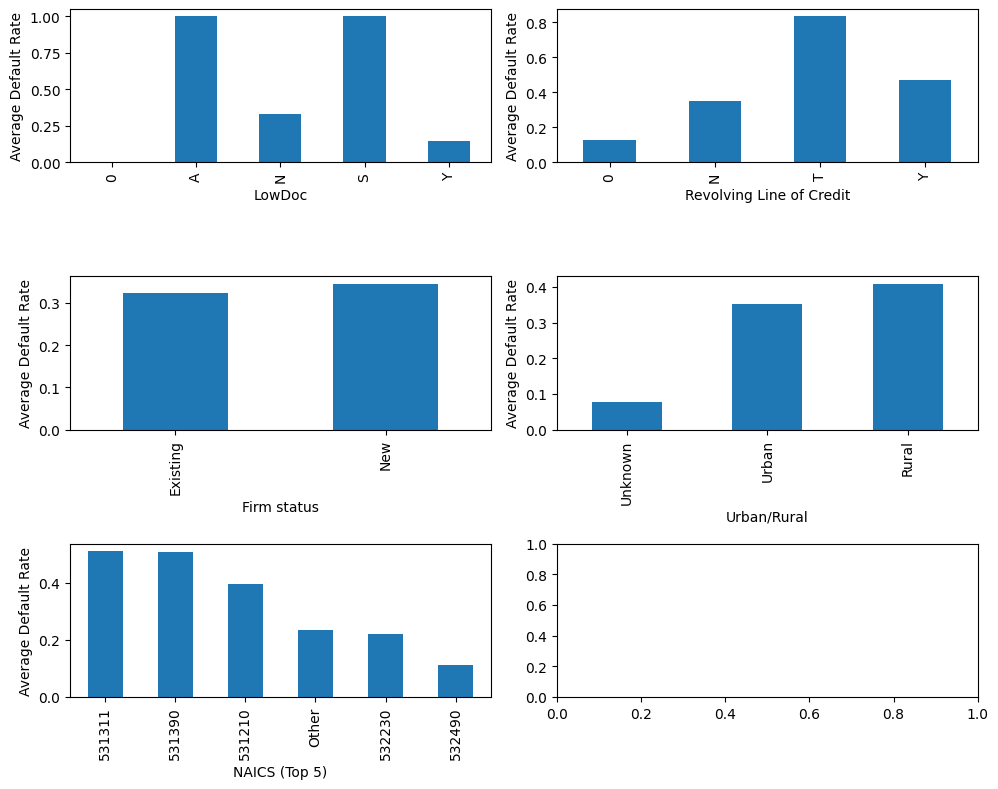

In [133]:
# ---------- Target/indicator ----------
# Make a binary delay indicator from the status column.
sba_df['Default'] = [
    1 if status == 'CHGOFF' else 0
    for status in sba_df['MIS_Status']
]

# ----- helper to draw one panel (avg default by category) -----
def createGraph(group, xlabel, axis):
    if group == 'NAICS':
        naics = sba_df['NAICS'].astype(str).str.strip()
        top = naics.value_counts().head().index  # show top 12 codes
        reduced = naics.where(naics.isin(top), other='Other')
        grp = sba_df.groupby(reduced)['Default'].mean().sort_values(ascending=False)
    else:
      grp = sba_df.groupby(group)['Default'].mean()
      # nice ordering for specific fields
      if group == 'NewExist':
          grp = grp.reindex([1, 2]).dropna()
          grp.index = ['Existing','New']
      if group == 'UrbanRural':
          grp = grp.reindex([0,1,2]).dropna()
          grp.index = ['Unknown','Urban','Rural']
      if group == 'ApprovalFY':
          grp = grp.sort_index()

    grp.plot.bar(color='C0', ax=axis)
    axis.set_xlabel(xlabel)
    axis.set_ylabel('Average Default Rate')

# ===== figure =====
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

createGraph('LowDoc', 'LowDoc', axis=axes[0][0])
createGraph('RevLineCr', 'Revolving Line of Credit', axis=axes[0][1])
createGraph('NewExist', 'Firm status', axis=axes[1][0])
createGraph('UrbanRural', 'Urban/Rural', axis=axes[1][1])
createGraph('NAICS',     'NAICS (Top 5)',    axis=axes[2][0])  # <- NAICS here

plt.tight_layout()
plt.show()
